# AI for Media Miniproject: Image generation of Bags

This notebook involves training an image generation model on a dataset of fashion bags and desserts in an attempt to create fushion images.

As there are quite a number of ways to manipulate images with AI, I will test out the results using GANs.

All code in this notebook is adapted from the [AI for Media Week 4 class notebooks](https://git.arts.ac.uk/tbroad/AI-4-Media-22-23/tree/main/Week%204.1%20Generative%20models%20for%20images).

## GAN Image Model ##

In [1]:
## IMPORT CELL ##
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from keras.layers import Dense
from matplotlib import pyplot as plt
import os
import gdown
from zipfile import ZipFile
import cv2

### Load in image dataset

In [2]:
import pathlib
DATASET_DIR = pathlib.Path('data')

In [3]:
dataset = keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    label_mode=None,
    image_size=(64, 64),
    batch_size=32,
)
dataset = dataset.map(lambda x: x / 255.0)

Found 4373 files belonging to 1 classes.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


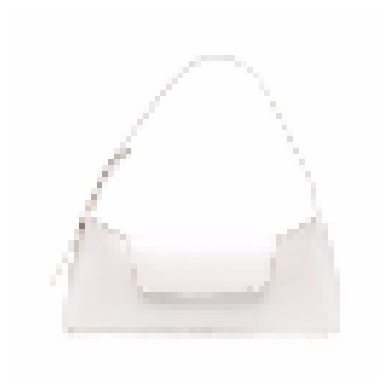

In [4]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

## Constructing the GAN

With our dataset installed, we need to build the the discriminator (encoder) and generator (decoder).

In [5]:
                              ## Building the discriminator ##

discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

In [6]:
                                 ## Building the generator ##

latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

In [7]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [8]:
path ='results'

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(os.path.join(path, "generated_img_%03d_%d.png" % (epoch, i)))


### Training the model and checking the results

In [43]:
epochs = 2  

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/2
137/137 [==============================] - 1904s 14s/step - d_loss: 0.6818 - g_loss: 0.9245
Epoch 2/2
137/137 [==============================] - 1994s 15s/step - d_loss: 0.6646 - g_loss: 1.0438


Below are some single images produced by one of the epoches of the GAN model.

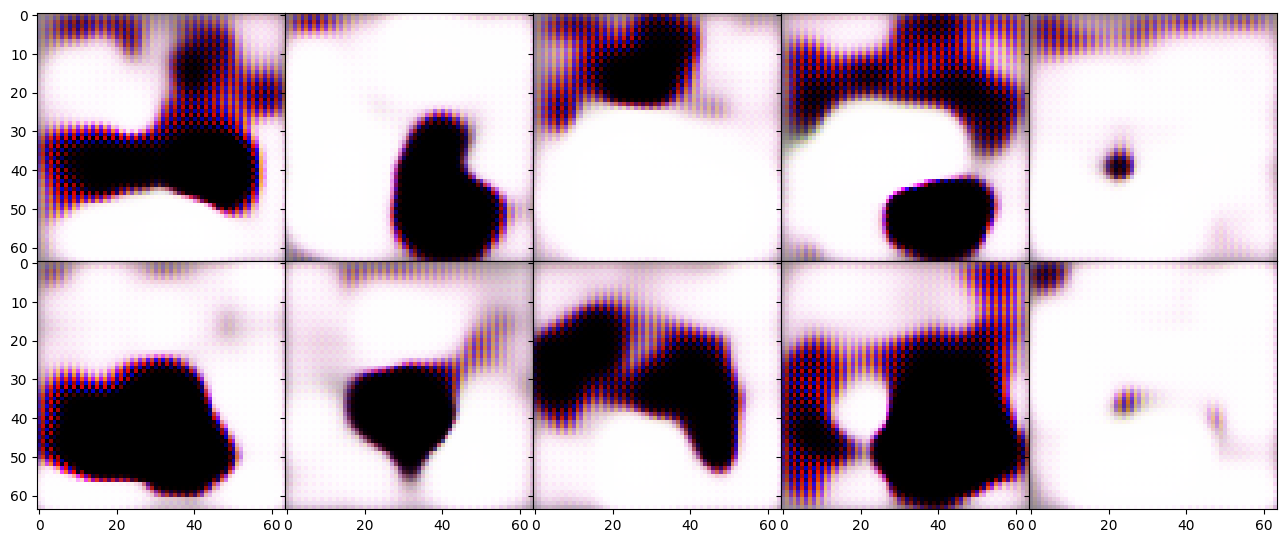

In [46]:
## EPOCH 1 ##

from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 5),  # creates 5x2 grid of axes
                 axes_pad=0,  # pad between axes in inch.
                 )

images = [f"results/generated_img_000_{x}.png" for x in range(10)]

for ax, im in zip(grid, images):
    # Iterating over the grid returns the Axes.
    img = mpimg.imread(im)
    ax.imshow(img)

plt.show()

## GAN with 5 epochs

Instead of fusions of bags and desserts, our results are actually odd patterns of pixels.

We can also see what might happen if we add additional epochs to the model and examine what additional training does to the output. Below is the same model but trained with 5 epochs.

In [33]:
path ='results_2'

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(os.path.join(path, "generated_img_%03d_%d.png" % (epoch, i)))


In [31]:
epochs = 5  

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/5
137/137 [==============================] - 1525s 11s/step - d_loss: 0.3037 - g_loss: 2.5512
Epoch 2/5
137/137 [==============================] - 2061s 15s/step - d_loss: 0.5018 - g_loss: 1.4592
Epoch 3/5
137/137 [==============================] - 2030s 15s/step - d_loss: 0.4933 - g_loss: 1.5980
Epoch 4/5
137/137 [==============================] - 2035s 15s/step - d_loss: 0.7098 - g_loss: 1.0683
Epoch 5/5
137/137 [==============================] - 2016s 15s/step - d_loss: 0.5810 - g_loss: 1.4013


Let's see what results we got from this round of testing.

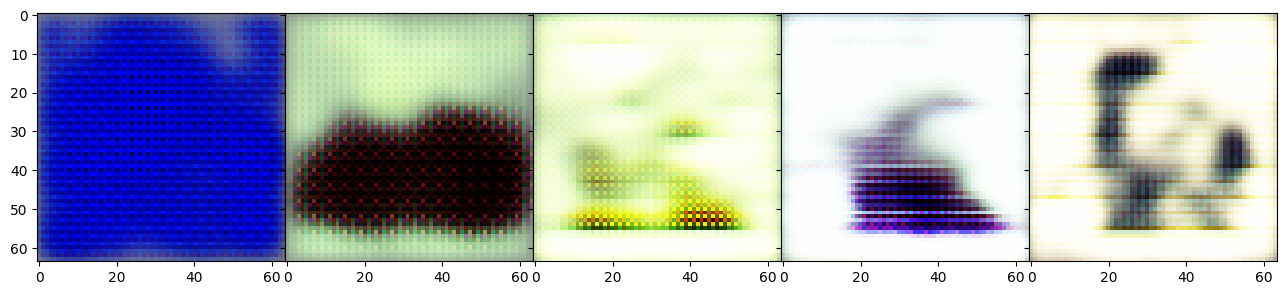

In [32]:
                    ## Show an image that was generated during each epoch ##

from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1,5),  # creates 5x2 grid of axes
                 axes_pad=0,  # pad between axes in inch.
                 )

images = [f"results_2/generated_img_00{x}_0.png" for x in range(5)]

for ax, im in zip(grid, images):
    # Iterating over the grid returns the Axes.
    img = mpimg.imread(im)
    ax.imshow(img)

plt.show()

Although I did not get the fusion dessert bags I was hoping for (although in order to do that, it would require a lot more tinkering and training of the model), the result I got are still very interesting. With 5 epochs, I got some very interesting patterns that remind me of the Y2K aesthetic with the vaporwave-esque filtering. However, there is some semblance of an object starting to form in these pictures, which means that if the model goes through more rounds of training, it should be able to produce some more recognisable results.

## GAN with 30 epochs

Finally, I will train my GAN with 30 epochs, as this is the minimum requirement that is also suitable with my laptop's ability.

In [34]:
path ='results_30'

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(os.path.join(path, "generated_img_%03d_%d.png" % (epoch, i)))


In [36]:
epochs = 30  

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/30
137/137 [==============================] - 5300s 39s/step - d_loss: 0.6775 - g_loss: 0.9420
Epoch 2/30
137/137 [==============================] - 1618s 12s/step - d_loss: 0.5627 - g_loss: 1.5765
Epoch 3/30
137/137 [==============================] - 1321s 10s/step - d_loss: 0.7075 - g_loss: 0.8469
Epoch 4/30
137/137 [==============================] - 1281s 9s/step - d_loss: 0.6269 - g_loss: 1.0726
Epoch 5/30
137/137 [==============================] - 1246s 9s/step - d_loss: 0.6412 - g_loss: 1.0052
Epoch 6/30
137/137 [==============================] - 1249s 9s/step - d_loss: 0.6069 - g_loss: 1.0856
Epoch 7/30
137/137 [==============================] - 1250s 9s/step - d_loss: 0.6258 - g_loss: 1.0286
Epoch 8/30
137/137 [==============================] - 1244s 9s/step - d_loss: 0.5974 - g_loss: 1.1852
Epoch 9/30
137/137 [==============================] - 1281s 9s/step - d_loss: 0.6148 - g_loss: 1.2604
Epoch 10/30
137/137 [==============================] - 1273s 9s/step - d_loss: 

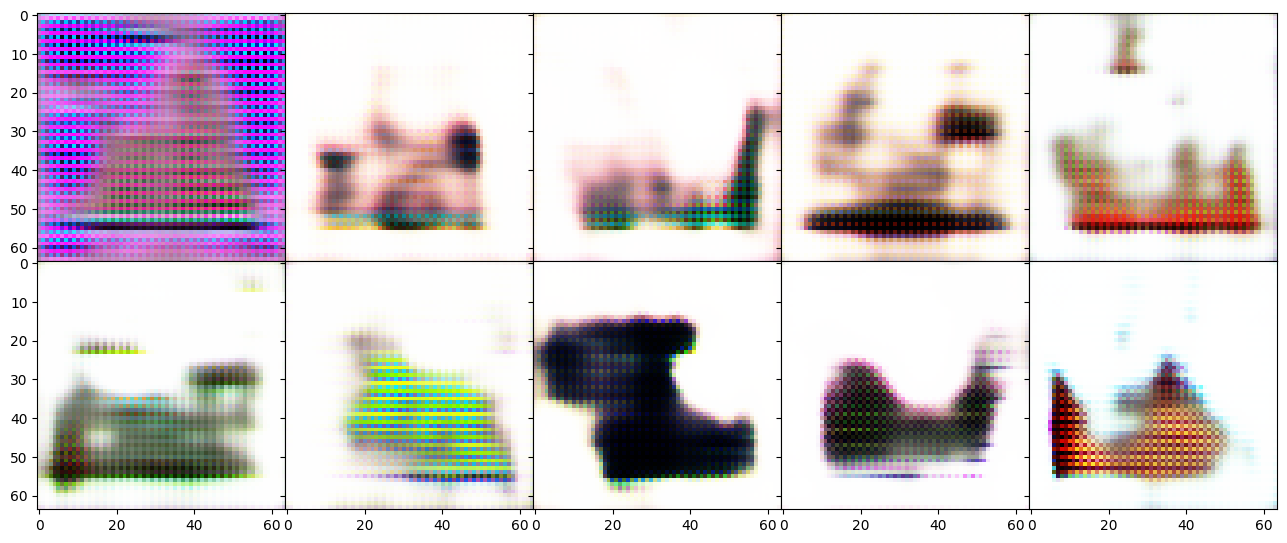

In [41]:
             ## Show an image that was generated during the first 10 epochs ##

from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2,5),  # creates 5x2 grid of axes
                 axes_pad=0,  # pad between axes in inch.
                 )

images = [f"results_30/generated_img_00{x}_0.png" for x in range(10)]

for ax, im in zip(grid, images):
    # Iterating over the grid returns the Axes.
    img = mpimg.imread(im)
    ax.imshow(img)

plt.show()

## GAN with 50 epochs

In [38]:
path ='results_50'

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(os.path.join(path, "generated_img_%03d_%d.png" % (epoch, i)))


In [39]:
epochs = 50  

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/50
137/137 [==============================] - 1480s 11s/step - d_loss: 0.6294 - g_loss: 0.9835
Epoch 2/50
137/137 [==============================] - 1504s 11s/step - d_loss: 0.7456 - g_loss: 0.9868
Epoch 3/50
137/137 [==============================] - 1602s 12s/step - d_loss: 0.6239 - g_loss: 0.9919
Epoch 4/50
137/137 [==============================] - 1661s 12s/step - d_loss: 0.6662 - g_loss: 1.0572
Epoch 5/50
137/137 [==============================] - 1712s 12s/step - d_loss: 0.6495 - g_loss: 0.9481
Epoch 6/50
137/137 [==============================] - 1644s 12s/step - d_loss: 0.5837 - g_loss: 1.0900
Epoch 7/50
137/137 [==============================] - 1544s 11s/step - d_loss: 0.6504 - g_loss: 1.2889
Epoch 8/50
137/137 [==============================] - 1615s 12s/step - d_loss: 0.6799 - g_loss: 1.0558
Epoch 9/50
137/137 [==============================] - 1621s 12s/step - d_loss: 0.6287 - g_loss: 1.0319
Epoch 10/50
137/137 [==============================] - 1640s 12s/step - d

KeyboardInterrupt: 

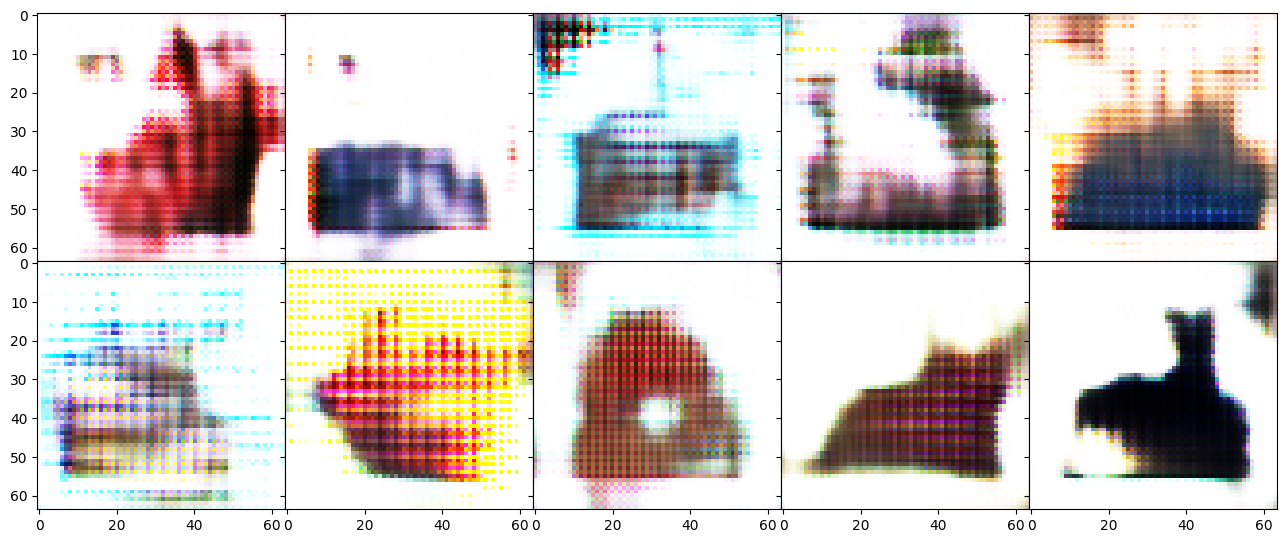

In [42]:
## Show an image that was generated during the first 10 epochs ##

from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2,5),  # creates 5x2 grid of axes
                 axes_pad=0,  # pad between axes in inch.
                 )

images = [f"results_50/generated_img_00{x}_0.png" for x in range(10)]

for ax, im in zip(grid, images):
    # Iterating over the grid returns the Axes.
    img = mpimg.imread(im)
    ax.imshow(img)

plt.show()

Unfortunately, due to the specs of my laptop, I was not able to train the entire 50 epochs. However, looking at some of the results of the first 10 epochs show that images of bags are starting to form (especially compared the GAN trained with 30 epochs), although, the images are not clear enough to tell if the dessert images in the dataset had any effect on the output. This means that the GAN may still require more training. Nonetheless, the model was still able to produce some very fun patterns,